<a href="https://colab.research.google.com/github/IG-Reagan/SAS-2024-Customer-Segmentation-with-Clustering/blob/main/customer_segmentation_with_clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Customer Segmentation with Clustering

This project applies unsupervised machine learning to segment e-commerce customers using clustering methods.  The dataset (SAS, 2024) covers ~68k customers across 47 countries, with transactions from 2012–2016. Key techniques include feature engineering (Frequency, Recency, CLV, Avg. Unit Cost, Age), dimensionality reduction (PCA, t-SNE), and clustering (KMeans, Hierarchical). The final KMeans model identified 4 customer segments, providing insights for targeted marketing and retention strategies.

**1. Import the required libraries and data set with the provided URL.**

In [ ]:
# Install gdown to download the files from google drive

!pip install gdown

In [ ]:
!gdown 'https://drive.google.com/uc?export=download&id=1S5wniOV5_5htDfUFeZhlCLibvtihNLKK'

Downloading...
From (original): https://drive.google.com/uc?export=download&id=1S5wniOV5_5htDfUFeZhlCLibvtihNLKK
From (redirected): https://drive.google.com/uc?export=download&id=1S5wniOV5_5htDfUFeZhlCLibvtihNLKK&confirm=t&uuid=cddc3770-0715-46c7-8bf0-4a7f34f48557
To: /content/CUSTOMERS_CLEAN.csv
100% 191M/191M [00:02<00:00, 72.8MB/s]


In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as stats
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Import downloaded dataset

download = 'CUSTOMERS_CLEAN.csv'
# data = pd.read_csv(url, parse_dates=['Order_Date', 'Delivery_Date', 'Customer_BirthDate'])
data = pd.read_csv(download)

In [ ]:
# View the dataset

data.head(3)

,Quantity,City,Continent,Postal_Code,State_Province,Order_Date,Delivery_Date,Total Revenue,Unit Cost,Discount,OrderTypeLabel,CustomerCountryLabel,Customer_BirthDate,Customer_Group,Customer_Type,Order ID,Profit,Days to Delivery,Loyalty Num,Customer ID
0,3,Leinster,Oceania,6437,Western Australia,01JAN2012,07JAN2012,$28.50,$9.10,.,Internet Sale,Australia,08MAY1978,Internet/Catalog Customers,Internet/Catalog Customers,1230000033,$1.20,6,99,8818
1,2,Berowra,Oceania,2081,New South Wales,01JAN2012,04JAN2012,$113.40,$56.90,.,Internet Sale,Australia,13DEC1978,Orion Club Gold members,Orion Club Gold members high activity,1230000204,($0.40),3,99,47793
2,2,Berowra,Oceania,2081,New South Wales,01JAN2012,04JAN2012,$41.00,$18.50,.,Internet Sale,Australia,13DEC1978,Orion Club Gold members,Orion Club Gold members high activity,1230000204,$4.00,3,99,47793


In [ ]:
# Check the data shape

data.shape

(951669, 20)

In [ ]:
# Display the dataset info to have a general idea of the data

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 951669 entries, 0 to 951668
Data columns (total 20 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   Quantity              951669 non-null  int64 
 1   City                  951534 non-null  object
 2   Continent             951669 non-null  object
 3   Postal_Code           947953 non-null  object
 4   State_Province        834477 non-null  object
 5   Order_Date            951669 non-null  object
 6   Delivery_Date         951669 non-null  object
 7   Total Revenue         951669 non-null  object
 8   Unit Cost             951669 non-null  object
 9   Discount              951669 non-null  object
 10  OrderTypeLabel        951669 non-null  object
 11  CustomerCountryLabel  951669 non-null  object
 12  Customer_BirthDate    951669 non-null  object
 13  Customer_Group        951669 non-null  object
 14  Customer_Type         951669 non-null  object
 15  Order ID         

In [ ]:
# Check how many records vs unique Customer ID

print('number of records', len(data['Customer ID']))
print('number of unique customers', data['Customer ID'].nunique())

number of records 951669
number of unique customers 68300


There are over 950 thousand order transactions but only 63,800 unique customers.

There are some missing values as seen in the table, let us view the sum of

**2.1. Identify missing values**

In [ ]:
# Check the sum of missing values per feature

data.isna().sum()

Quantity                     0
City                       135
Continent                    0
Postal_Code               3716
State_Province          117192
Order_Date                   0
Delivery_Date                0
Total Revenue                0
Unit Cost                    0
Discount                     0
OrderTypeLabel               0
CustomerCountryLabel         0
Customer_BirthDate           0
Customer_Group               0
Customer_Type                0
Order ID                     0
Profit                       0
Days to Delivery             0
Loyalty Num                  0
Customer ID                  0
dtype: int64

There are 3 features with missing values, namely; City, Postal_Code and State_Province. Missing values in State_Province seems quite high. Let's check the proportions of missing values in the columns.

In [ ]:
# Find out the proportion missing values per column

data.isna().mean() * 100

Quantity                 0.000000
City                     0.014186
Continent                0.000000
Postal_Code              0.390472
State_Province          12.314366
Order_Date               0.000000
Delivery_Date            0.000000
Total Revenue            0.000000
Unit Cost                0.000000
Discount                 0.000000
OrderTypeLabel           0.000000
CustomerCountryLabel     0.000000
Customer_BirthDate       0.000000
Customer_Group           0.000000
Customer_Type            0.000000
Order ID                 0.000000
Profit                   0.000000
Days to Delivery         0.000000
Loyalty Num              0.000000
Customer ID              0.000000
dtype: float64

City and Postal_Code have less than 1% of missing values, hence the missing rows will be dropped. As for State_Province, we can try to fill those based on City.

In [ ]:
# Drop rows with null values in City and Postal_Code columns.

data_2 = data.dropna(subset=['City', 'Postal_Code'])
print('New shape of the dataset is: ', data_2.shape)

# Check percentage of data records left

percentage_rows_left = data_2.shape[0] / data.shape[0]*100
print('Percentage of rows left:', round(percentage_rows_left,2), '%')

New shape of the dataset is:  (947818, 20)
Percentage of rows left: 99.6 %


In [ ]:
# Filter out countries with missing values in the 'State_Province' column

countries_with_missing_states = data_2[data_2['State_Province'].isna()]['CustomerCountryLabel'].unique()
print(len(countries_with_missing_states), 'countries with missing values in State_Province column')
print(countries_with_missing_states)

35 countries with missing values in State_Province column
['Switzerland' 'Denmark' 'Netherlands' 'Portugal' 'Austria' 'Finland'
 'Ireland' 'Norway' 'Luxembourg' 'Greece' 'Sweden' 'Turkey' 'South Africa'
 'Slovenia' 'Hungary' 'Macedonia' 'Bulgaria' 'Lithuania' 'Morocco'
 'New Zealand' 'Serbia' 'Estonia' 'Saudi Arabia' 'Czech Republic'
 'Senegal' 'Nigeria' 'Russian Federation' 'Singapore' 'Andorra' 'Croatia'
 'Benin' 'Tunisia' 'Poland' 'Belgium' 'Mozambique']


In [ ]:
# View all 35 countries with missing values in the 'State_Province' column

def count_missing_vals(series):
    missing_count = series.isna().sum()
    return missing_count

missing_df = data_2.groupby(['CustomerCountryLabel'])['State_Province'].agg(count='count', nulls=count_missing_vals)
missing_df = missing_df.sort_values(by=['nulls'], ascending=False)
print("List showing the 35 countries with missing values in the 'State_Province' column")
print(missing_df.head(40)) # View the top 40 countries with the highest number of missing values

List showing the 35 countries with missing values in the 'State_Province' column
                       count  nulls
CustomerCountryLabel               
Netherlands                0  62533
Belgium                    0  24943
Denmark                    0  17999
Portugal                   0   1720
Switzerland                0   1577
Austria                    0   1501
Finland                    0   1271
Norway                     0   1114
Sweden                     0   1056
Turkey                     0    776
South Africa               0    658
Slovenia                   0    342
Luxembourg                 0    247
Greece                     0    232
Hungary                    0    184
Ireland                    0    127
Serbia                     0     87
New Zealand                0     77
Andorra                    0     73
Russian Federation         0     66
Croatia                    0     64
Singapore                  0     49
Saudi Arabia               0     42
Poland             

The list shows that State_Province was not entered for records in 35 countries, therefore this column will not be used. 'City' will be used instead.

In [ ]:
# Drop State_Province column and view dataset info again
data_3 = data_2.drop(columns = ['State_Province'], axis=1)

#  Check percentage of null values by row
data_3.info()

<class 'pandas.core.frame.DataFrame'>
Index: 947818 entries, 0 to 951668
Data columns (total 19 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   Quantity              947818 non-null  int64 
 1   City                  947818 non-null  object
 2   Continent             947818 non-null  object
 3   Postal_Code           947818 non-null  object
 4   Order_Date            947818 non-null  object
 5   Delivery_Date         947818 non-null  object
 6   Total Revenue         947818 non-null  object
 7   Unit Cost             947818 non-null  object
 8   Discount              947818 non-null  object
 9   OrderTypeLabel        947818 non-null  object
 10  CustomerCountryLabel  947818 non-null  object
 11  Customer_BirthDate    947818 non-null  object
 12  Customer_Group        947818 non-null  object
 13  Customer_Type         947818 non-null  object
 14  Order ID              947818 non-null  int64 
 15  Profit                

New dataset shows 19 columns and 951,668 rows. There are no missing values.

**2.2. Check for duplicates**

In [ ]:
# Check for duplicated rows

duplicated_rows = data_3.duplicated().sum()
print('Number of duplicated records: ', duplicated_rows)

Number of duplicated records:  21


In [ ]:
# Drop duplicated rows

data_3 = data_3.drop_duplicates()


# Check duplicated rows again

duplicated_rows = data_3.duplicated().sum()
print('Number of duplicated records: ', duplicated_rows)
print('Shape of dataset:', data_3.shape)

Number of duplicated records:  0
Shape of dataset: (947797, 19)


Duplicated rows have now been removed.

**2.3. Determine if there are any outliers**

In [ ]:
# Import the re library to convert currency to floats
import re

# Function to convert currency strings to float
def currency_to_float(currency_str):
    # Check if the currency string is negative and remove parentheses if present
    is_negative = '(' in currency_str and ')' in currency_str
    clean_str = re.sub(r'[^\d.]+', '', currency_str)

    try:
        value = float(clean_str)
        if is_negative:
            value = -value
        return value
    except ValueError:
        return float('nan')

# Apply the custom function to the 'Total Revenue' column
data_3['Total Revenue'] = data_3['Total Revenue'].apply(currency_to_float)
data_3['Unit Cost'] = data_3['Unit Cost'].apply(currency_to_float)
data_3['Profit'] = data_3['Profit'].apply(currency_to_float)

In [ ]:
data_3.head(3)

,Quantity,City,Continent,Postal_Code,Order_Date,Delivery_Date,Total Revenue,Unit Cost,Discount,OrderTypeLabel,CustomerCountryLabel,Customer_BirthDate,Customer_Group,Customer_Type,Order ID,Profit,Days to Delivery,Loyalty Num,Customer ID
0,3,Leinster,Oceania,6437,01JAN2012,07JAN2012,28.5,9.1,.,Internet Sale,Australia,08MAY1978,Internet/Catalog Customers,Internet/Catalog Customers,1230000033,1.2,6,99,8818
1,2,Berowra,Oceania,2081,01JAN2012,04JAN2012,113.4,56.9,.,Internet Sale,Australia,13DEC1978,Orion Club Gold members,Orion Club Gold members high activity,1230000204,-0.4,3,99,47793
2,2,Berowra,Oceania,2081,01JAN2012,04JAN2012,41.0,18.5,.,Internet Sale,Australia,13DEC1978,Orion Club Gold members,Orion Club Gold members high activity,1230000204,4.0,3,99,47793


In [ ]:
# Check descriptive statistics of the numeric variables

num_columns = ['Total Revenue', 'Unit Cost', 'Profit', 'Quantity']
data_3[num_columns].describe().T

,count,mean,std,min,25%,50%,75%,max
Total Revenue,947797.0,139.784785,185.427516,0.63,39.8,84.1,171.2,9385.8
Unit Cost,947797.0,77.707056,85.116500,0.40,26.3,50.5,98.9,1583.6
Profit,947797.0,8.647679,33.082996,-1222.48,0.1,4.4,11.9,2121.6
Quantity,947797.0,1.677732,0.899760,1.00,1.0,1.0,2.0,10.0


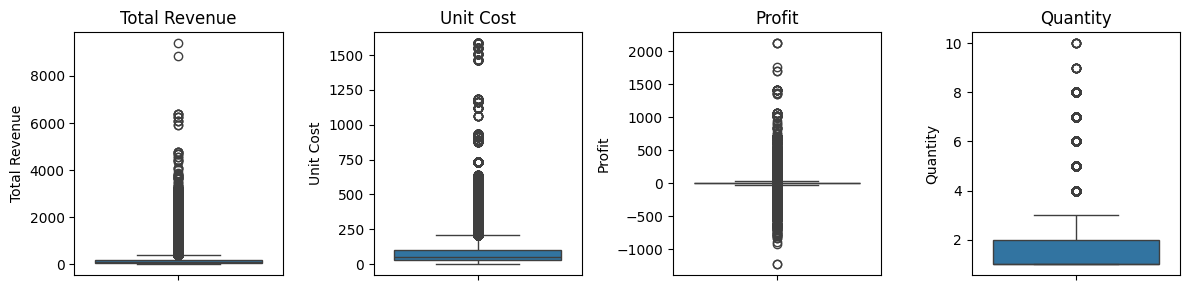

In [ ]:
# Use a boxplot to check the statistical distribution of the numberic columns; Total Revenue, Unit Cost and Profit
fig, ax = plt.subplots(1, 4, figsize=(12, 3))

# Plot boxplots for different columns
sns.boxplot(y='Total Revenue', data=data_3, ax=ax[0])
ax[0].set_title('Total Revenue')

sns.boxplot(y='Unit Cost', data=data_3, ax=ax[1])
ax[1].set_title('Unit Cost')

sns.boxplot(y='Profit', data=data_3, ax=ax[2])
ax[2].set_title('Profit')

sns.boxplot(y='Quantity', data=data_3, ax=ax[3])
ax[3].set_title('Quantity')

plt.tight_layout()
plt.show()

It's difficult to tell if any data point is an outlier based on their individual distributions. Let's create interractions in the dataset such as 'Unit Price' and then, use scatter plots to visualise 'Unit Price' vs 'Unit Cost', 'Unit Cost' vs 'Profit', etc.

In [ ]:
data_3['Unit Price'] = data_3['Total Revenue'] / data_3['Quantity']
data_3['Profit_check'] = data_3['Total Revenue'] - (data_3['Unit Cost'] * data_3['Quantity'])

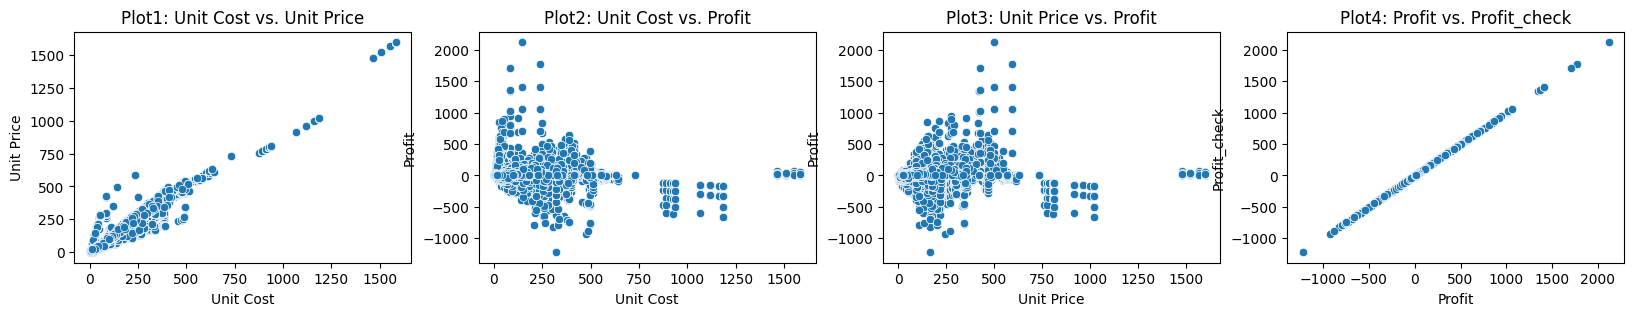

In [ ]:
fig, ax = plt.subplots(1,4, figsize=(20,3))

sns.scatterplot(x='Unit Cost', y='Unit Price', data=data_3, ax=ax[0])
ax[0].set_title('Plot1: Unit Cost vs. Unit Price')

sns.scatterplot(x='Unit Cost', y='Profit', data=data_3, ax=ax[1])
ax[1].set_title('Plot2: Unit Cost vs. Profit')

sns.scatterplot(x='Unit Price', y='Profit', data=data_3, ax=ax[2])
ax[2].set_title('Plot3: Unit Price vs. Profit')

sns.scatterplot(x='Profit', y='Profit_check', data=data_3, ax=ax[3])
ax[3].set_title('Plot4: Profit vs. Profit_check')

plt.show()

As seen in the descriptive statistics, Plot2 and Plot3 show a negative profit less than -1000, with a cost around 300 and a price less than 250. Let's filter to view more details about the order(s) invlolved.

In [ ]:
# View record with profit < -1000

data_3[data_3['Profit'] < -1000]

,Quantity,City,Continent,Postal_Code,Order_Date,Delivery_Date,Total Revenue,Unit Cost,Discount,OrderTypeLabel,...,Customer_BirthDate,Customer_Group,Customer_Type,Order ID,Profit,Days to Delivery,Loyalty Num,Customer ID,Unit Price,Profit_check
387300,8,Alden,North America,56009,03APR2014,06APR2014,1327.92,318.8,50%,Internet Sale,...,11AUG1978,Orion Club members,Orion Club members high activity,1235374806,-1222.48,3,99,13526,165.99,-1222.48
398998,8,Ivry Sur Seine,Europe,94856,21APR2014,21APR2014,1327.92,318.8,50%,Retail Sale,...,08FEB1995,Orion Club Gold members,Orion Club Gold members medium activity,1235555700,-1222.48,0,99,75667,165.99,-1222.48


Two orders show a loss (negative profit) of over 1000. By filtering these records we can see that there was a 50% discount applied on the sale which led to selling below the unit cost, hence negative profit. There is no clear indication that these records are outliers.

**3. Perform feature engineering**

**3.1. Create new features for frequency, recency, CLV, average unit cost, and customer age.**

**Frequency** indicates how often a customer purchases over a given period of time. A high frequency indicates a loyal customer, a high level of satisfaction, trust or brand loyalty, and/or effective marketing efforts. Frequency based on purchases guides a business in the effectiveness of target marketing campaigns and how to target less active customers.

In [ ]:
# Create new feature for frequency

data_4 = data_3
data_4['Frequency'] = data_4.groupby('Customer ID')['Order ID'].transform('size')
data_4.head()

,Quantity,City,Continent,Postal_Code,Order_Date,Delivery_Date,Total Revenue,Unit Cost,Discount,OrderTypeLabel,...,Customer_Group,Customer_Type,Order ID,Profit,Days to Delivery,Loyalty Num,Customer ID,Unit Price,Profit_check,Frequency
0,3,Leinster,Oceania,6437,01JAN2012,07JAN2012,28.5,9.1,.,Internet Sale,...,Internet/Catalog Customers,Internet/Catalog Customers,1230000033,1.2,6,99,8818,9.5,1.2,31
1,2,Berowra,Oceania,2081,01JAN2012,04JAN2012,113.4,56.9,.,Internet Sale,...,Orion Club Gold members,Orion Club Gold members high activity,1230000204,-0.4,3,99,47793,56.7,-0.4,20
2,2,Berowra,Oceania,2081,01JAN2012,04JAN2012,41.0,18.5,.,Internet Sale,...,Orion Club Gold members,Orion Club Gold members high activity,1230000204,4.0,3,99,47793,20.5,4.0,20
3,1,Northbridge,Oceania,2063,01JAN2012,03JAN2012,35.2,29.6,.,Internet Sale,...,Orion Club Gold members,Orion Club Gold members high activity,1230000268,5.6,2,0,71727,35.2,5.6,20
5,1,Herrenschwanden,Europe,3037,01JAN2012,07JAN2012,136.1,132.2,.,Internet Sale,...,Orion Club Gold members,Orion Club Gold members medium activity,1230000494,3.9,6,99,8610,136.1,3.9,3


**Recency** measures how recently a customer made a purchase or placed an order. It helps predict customer churn (turnover) and engagement. A customer is a business’s most valuable asset, so securing customer retention is essential. A high recency indicates customer satisfaction and engagement. One customer should appear only once in the final dataset, and the recency will be the min number of days until today.

In [ ]:
# Calculate recency as the difference in days between each row order date from the very first order in the dataset.
# A higher number of days will indicate a more recent order.

# Convert Order date to datetime format
data_4['Order_Date'] = pd.to_datetime(data_4['Order_Date'])

# Earliest order date
first_order_date = data_4['Order_Date'].min()

# Calculate the number of days from the first order date
data_4['Recency'] = (data_4['Order_Date'] - first_order_date).dt.days

# Display first order date and dataframe showing the last 3 orders
print('First order was placed on: ', first_order_date)
data_4.sort_values('Order_Date', ascending = False).head(3)

First order was placed on:  2012-01-01 00:00:00


,Quantity,City,Continent,Postal_Code,Order_Date,Delivery_Date,Total Revenue,Unit Cost,Discount,OrderTypeLabel,...,Customer_Type,Order ID,Profit,Days to Delivery,Loyalty Num,Customer ID,Unit Price,Profit_check,Frequency,Recency
951668,2,Watertown,North America,13601,2016-12-30,30DEC2016,43.98,14.5,.,Retail Sale,...,Orion Club members low activity,1244337638,14.98,0,99,65008,21.99,14.98,8,1825
951380,2,St Chamond,Europe,42403,2016-12-30,04JAN2017,18.80,8.0,.,Catalog Sale,...,Orion Club Gold members high activity,1244334627,2.80,5,0,49401,9.40,2.80,34,1825
951369,2,Saint Maurice,Europe,94110,2016-12-30,30DEC2016,38.40,16.0,.,Retail Sale,...,Orion Club Gold members high activity,1244334489,6.40,0,99,19815,19.20,6.40,49,1825


**Customer lifetime value (CLV)** indicates the average or total value a customer contributes to a business over the course of their relationship. In other words, CLV is a metric of the total income a business can expect to generate from a customer as long as said customer remains a loyal client. CLV helps to prioritise marketing efforts and resources as it focuses on customers who are expected to bring the most value over time. Therefore, retaining high-value customers.

**Note:** Total Revenue column has already been converted into float in step 2.3. using the custom function currency_to_float, therefore no action needed. When grouping the data by Customer ID, the Total Renunue column will be aggregated by sum.

**The average unit cost** indicates the profitability of purchases. Customers buying products with a higher average unit cost price should be given preference as this ensures a steady profit. Customer segmentation assists in identifying these customers.

**Note:** The Unit Cost column has already been converted from currency to float in step 2.3. using the custom function currency_to_float. This will be aggregated by mean when grouping by Customer ID.

**Customer Age** to obtain insight from customer ages, a new variable named 'Customer_Age' will be created by subtracting Customer_BirthDate from today's date and converting to years.

In [ ]:
# Create new feature named 'Customer_Age'

data_4['Customer_Age'] = (pd.to_datetime('today') - pd.to_datetime(data_4['Customer_BirthDate'])).dt.days // 365

In [ ]:
data_4.head()

,Quantity,City,Continent,Postal_Code,Order_Date,Delivery_Date,Total Revenue,Unit Cost,Discount,OrderTypeLabel,...,Order ID,Profit,Days to Delivery,Loyalty Num,Customer ID,Unit Price,Profit_check,Frequency,Recency,Customer_Age
0,3,Leinster,Oceania,6437,2012-01-01,07JAN2012,28.5,9.1,.,Internet Sale,...,1230000033,1.2,6,99,8818,9.5,1.2,31,0,46
1,2,Berowra,Oceania,2081,2012-01-01,04JAN2012,113.4,56.9,.,Internet Sale,...,1230000204,-0.4,3,99,47793,56.7,-0.4,20,0,45
2,2,Berowra,Oceania,2081,2012-01-01,04JAN2012,41.0,18.5,.,Internet Sale,...,1230000204,4.0,3,99,47793,20.5,4.0,20,0,45
3,1,Northbridge,Oceania,2063,2012-01-01,03JAN2012,35.2,29.6,.,Internet Sale,...,1230000268,5.6,2,0,71727,35.2,5.6,20,0,26
5,1,Herrenschwanden,Europe,3037,2012-01-01,07JAN2012,136.1,132.2,.,Internet Sale,...,1230000494,3.9,6,99,8610,136.1,3.9,3,0,61


Create a new variable called Discount_Applied. This variable should indicate 1 if discount was applied to an Order ID and 0 if there was no discount applied. This variable will be aggregated as sum when grouping each unique Customer ID, and the sum of the Discount_Applied will indicate how many times a customer has purchased with a discount. Knowing customers that usually purchase discounted goods will enable the seller to target these customers with tailored discounts to increase their patronage.

In [ ]:
# View unique values in the Discount column

print(data_4['Discount'].unique())

['   .' '50%' '40%' '30%' '60%']


In [ ]:
# Create new column using a for loop

for i, row in data_4.iterrows():
  if row['Discount'] == '   .':
    data_4.at[i, 'Discount_Applied'] = 0
  else:
    data_4.at[i, 'Discount_Applied'] = 1

In [ ]:
print(data_4['Discount_Applied'].unique())

[0. 1.]


Discount_Applied is a new column that checks each transaction whether a discount was applied or not, and then takes the value of 1 for any discounted order, and 0 for orders without discount. An aggregation will be applied that sums the number of discounted orders for each customer.

**3.2. and 3.3. Feature selection and droping unnecessary features**

In [ ]:
print('Unique OrderTypeLabels - types of order placement channels: ', '\n', data_4['OrderTypeLabel'].unique())
print('')
print('Unique Customer_Groups - customer loyalty status: ', '\n', data_4['Customer_Group'].unique())

Unique OrderTypeLabels - types of order placement channels:  
 ['Internet Sale' 'Retail Sale' 'Catalog Sale']

Unique Customer_Groups - customer loyalty status:  
 ['Internet/Catalog Customers' 'Orion Club Gold members'
 'Orion Club members']


In [ ]:
# Select features into an aggregate dataset with each customer per row by grouping each feature by Customer_ID

# Sort data by Recency in order to priorities information from the more recent orders over older ones
data_4_sorted = data_4.sort_values('Recency', ascending = False)

# Create the aggregate dataset grouped by Customer_ID with all features to be selected
data_aggr = data_4_sorted.groupby('Customer ID').agg({'Continent': 'first',
                                                      'CustomerCountryLabel': 'first',
                                                      'Customer_Type': 'first',
                                                      'City': 'first', # Takes the customers most recent city in case they have recently relocated
                                                      'Customer_Group': 'first', # Selects the most recent Customer_Group label, taking into account if the customer has recently changed status
                                                      'OrderTypeLabel': 'first', # Takes the first OrderLabel in the series which should be the most recent as sorted by Recency
                                                      'Total Revenue': 'sum',
                                                      'Unit Cost': 'mean',
                                                      'Frequency': 'max',
                                                      'Recency': 'max',
                                                      'Customer_Age': 'max',
                                                      'Discount_Applied': 'sum'}).reset_index()

# Rename total Revenue to CLV and Unit Cost to Avg_Unit_Cost
data_aggr = data_aggr.rename(columns = {'Total Revenue': 'CLV', 'Unit Cost': 'Avg_Unit_Cost'})

# View the first few rows of the aggregated dataset
data_aggr.head()

,Customer ID,Continent,CustomerCountryLabel,Customer_Type,City,Customer_Group,OrderTypeLabel,CLV,Avg_Unit_Cost,Frequency,Recency,Customer_Age,Discount_Applied
0,1,Europe,France,Orion Club Gold members high activity,Paris,Orion Club Gold members,Retail Sale,4322.70,89.622857,35,1808,70,0.0
1,3,Europe,Italy,Orion Club members high activity,Bologna,Orion Club members,Internet Sale,2821.00,90.505000,20,1701,40,0.0
2,4,North America,United States,Orion Club members low activity,Denver,Orion Club members,Retail Sale,782.67,37.195556,9,717,40,0.0
3,5,North America,United States,Orion Club Gold members medium activity,South Gate,Orion Club Gold members,Retail Sale,2810.98,107.947368,19,1820,35,0.0
4,6,Europe,Belgium,Orion Club members medium activity,Genk,Orion Club members,Internet Sale,1604.58,52.526667,15,1633,65,1.0


The variables are selected by first choosing the numeric type that provide more variance, and then picking categorical  variables that give insight about customers' loyalty status, preferred order channel (Retail, internet, catalog), as well as geographical details which complements the order channel.

In [ ]:
data_aggr.shape

(67290, 13)

**3.4. Perform feature scaling and encoding if needed**

Before performing feature scaling, let's check the descriptive statistics of the dataset.

In [ ]:
# View descriptive statistics of the data

round(data_aggr.describe(), 2).T

,count,mean,std,min,25%,50%,75%,max
Customer ID,67290.0,44931.90,27027.96,1.00,21869.25,43510.00,65298.50,94254.00
CLV,67290.0,1968.90,1723.16,0.63,714.12,1517.28,2731.25,18860.96
Avg_Unit_Cost,67290.0,78.74,36.97,0.50,57.72,73.46,92.35,1463.50
Frequency,67290.0,14.09,11.34,1.00,6.00,11.00,19.00,121.00
Recency,67290.0,1460.84,412.42,1.00,1292.00,1640.00,1781.00,1825.00
Customer_Age,67290.0,50.59,17.49,26.00,35.00,50.00,66.00,81.00
Discount_Applied,67290.0,0.14,0.39,0.00,0.00,0.00,0.00,4.00


Data shows there are 67,292 unique customers with no missing values for any of the features. It also shows a wide spread of values in most of the variables. Total Revenue, Unit Cost, Frequency and Customer_Age show the highest spreads.

In [ ]:
# Scale the data using the standard scaler

# Extract the selected features
X = data_aggr[['CLV', 'Avg_Unit_Cost', 'Frequency', 'Recency', 'Customer_Age', 'Discount_Applied']].values

scaler = StandardScaler()
scaled_X = scaler.fit_transform(X)

scaled_X

array([[ 1.3659899 ,  0.29425585,  1.84502022,  0.84175771,  1.10994049,
        -0.34854212],
       [ 0.49450075,  0.31811695,  0.5217764 ,  0.58231162, -0.60528374,
        -0.34854212],
       [-0.6884136 , -1.12385131, -0.4486024 , -1.80362258, -0.60528374,
        -0.34854212],
       ...,
       [ 4.26103194, -0.03873415,  3.08004778,  0.76416636, -0.03354233,
         2.23272568],
       [-0.29928154, -0.12832714, -0.53681865,  0.04159686,  0.30950251,
        -0.34854212],
       [-0.66570509,  0.45412844, -0.71325116, -0.90647253,  0.82406978,
        -0.34854212]])

**4. Perform EDA and create visualisations to explore the data and answer some initial questions**

This section will use descriptive analytics to visualise the distributions within - and relationships between variables.

a. Check distributions of CLV, Frequency and Age. **I'll use boxplot and histograms**

b. What is the distribution of orders by channel? **I'll use countplot of order channels**

c. How are orders distributed by continent and channels, and what continents generated the highest CLV? **I'll try countplot and barplots of continents & order channels**

d. How are customers distributed into Customer Groups and what Customer Groups are the majority of people subscribed into? **countplot of customer group**

e. What Customer Groups are generating the highest CLV on average? **barplot of Customer Group vs CLV**

f. Are the customers contributing highest CLV also buying the most expensive products or did they just order more frequently? **scatterplot of CLV vs Unit Cost and Frequency**

g. What is the relationship between Frequency and Recency? Have the most frequent customers been ordering recently? **scatter plot of frequency vs recency**

h. Are frequent customers getting more discounted prices? **barplot of frequency vs discount_applied**

i. How has Total Revenue evolved over the years in the different ordering channels (internet, retail or catalog)? **I'll use non-aggregated dataset (data_4) to plot order date vs Total Revenue, hue - OrderTypeLabel**

j. What associations exist between the selected features? **correlation heatmap of all numeric variables**

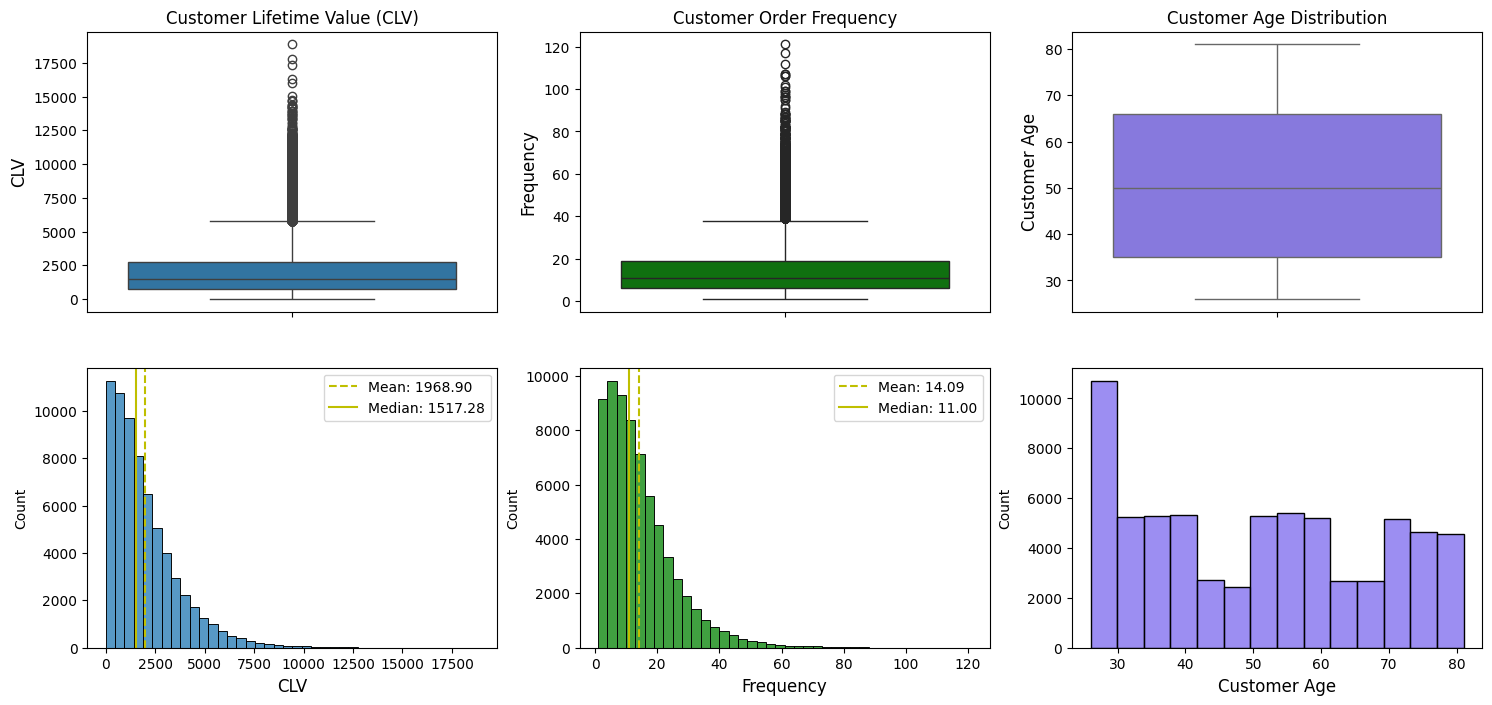

In [ ]:
# a. Check distributions of CLV, Frequency and Age

# Boxplots of CLV, Frequency and Age
fig, ax = plt.subplots(2,3, figsize=(18, 8))

sns.boxplot(data=data_aggr, y='CLV', ax=ax[0,0])
ax[0,0].set_title('Customer Lifetime Value (CLV)')
ax[0,0].set_ylabel('CLV', fontsize=12)

sns.boxplot(data=data_aggr, y='Frequency', ax=ax[0,1], color='green')
ax[0,1].set_title('Customer Order Frequency')
ax[0,1].set_ylabel('Frequency', fontsize=12)

sns.boxplot(data=data_aggr, y='Customer_Age', ax=ax[0,2], color='mediumslateblue')
ax[0,2].set_title('Customer Age Distribution')
ax[0,2].set_ylabel('Customer Age', fontsize=12)

# Histograms of CLV
sns.histplot(data=data_aggr, x='CLV', ax=ax[1,0], bins=40)
# Calculate mean and median lines
mean_value, median_value = data_aggr['CLV'].mean(), data_aggr['CLV'].median()
# Calculate mean and median
ax[1,0].axvline(mean_value, color='y', linestyle='--', label=f'Mean: {mean_value:.2f}')
ax[1,0].axvline(median_value, color='y', linestyle='-', label=f'Median: {median_value:.2f}')
ax[1,0].set_xlabel('CLV', fontsize=12)
ax[1,0].legend()

# Histograms of Frequency
sns.histplot(data=data_aggr, x='Frequency', ax=ax[1,1], bins=40, color='green')
# Calculate mean and median
mean_value, median_value = data_aggr['Frequency'].mean(), data_aggr['Frequency'].median()
# Add mean and median lines
ax[1,1].axvline(mean_value, color='y', linestyle='--', label=f'Mean: {mean_value:.2f}')
ax[1,1].axvline(median_value, color='y', linestyle='-', label=f'Median: {median_value:.2f}')
ax[1,1].set_xlabel('Frequency', fontsize=12)
ax[1,1].legend()

# Histograms of Age
sns.histplot(data=data_aggr, x='Customer_Age', ax=ax[1,2], bins=14, color='mediumslateblue')
ax[1,2].set_xlabel('Customer Age', fontsize=12)

plt.show()

a. Intepreting the boxplots and histograms together for the 5 years period under review shows that customer lifetime value (CLV) generated per customer ranges from about 0 up to over 17500, with majority of customers generating less than 2500 USD and only a select number of customers going above 7500 USD. In terms of customer order frequency, there are between about 1 to 120 orders per customer, but most customers ordered less than 20 times during the period. As for age distribution of customers, the majority age group is less than 30 years but in general customers ranged up to 80 years. On the average customers ordered 14 times with a CLV of almost 2,000 USD, while the median customer actually shopped 11 times and spent 1,517 USD in total. The distributions of both CLV and Frequency are right skewed, hence the mean is greater than median in both cases.

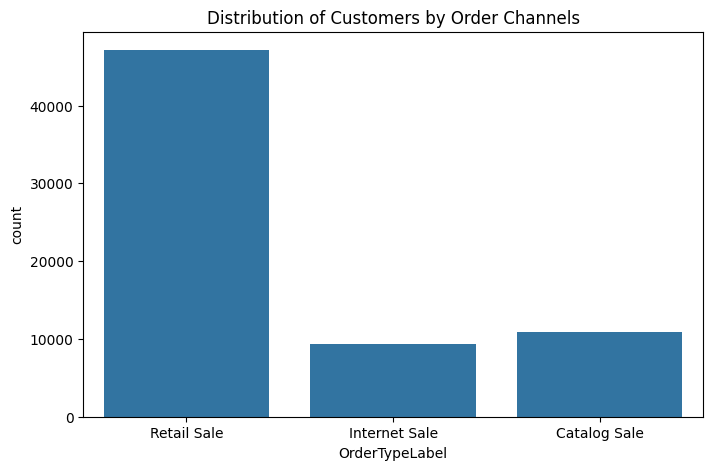

In [ ]:
# b. Distribution of orders by channel; countplot of OrderTypeLabel

plt.figure(figsize=(8,5))
sns.countplot(data=data_aggr, x='OrderTypeLabel')
plt.title('Distribution of Customers by Order Channels')

plt.show()

b. Majority of customers shopped in-store (Retail Sale), with Catalog and Internet Sales following with a relatively close share of customers.

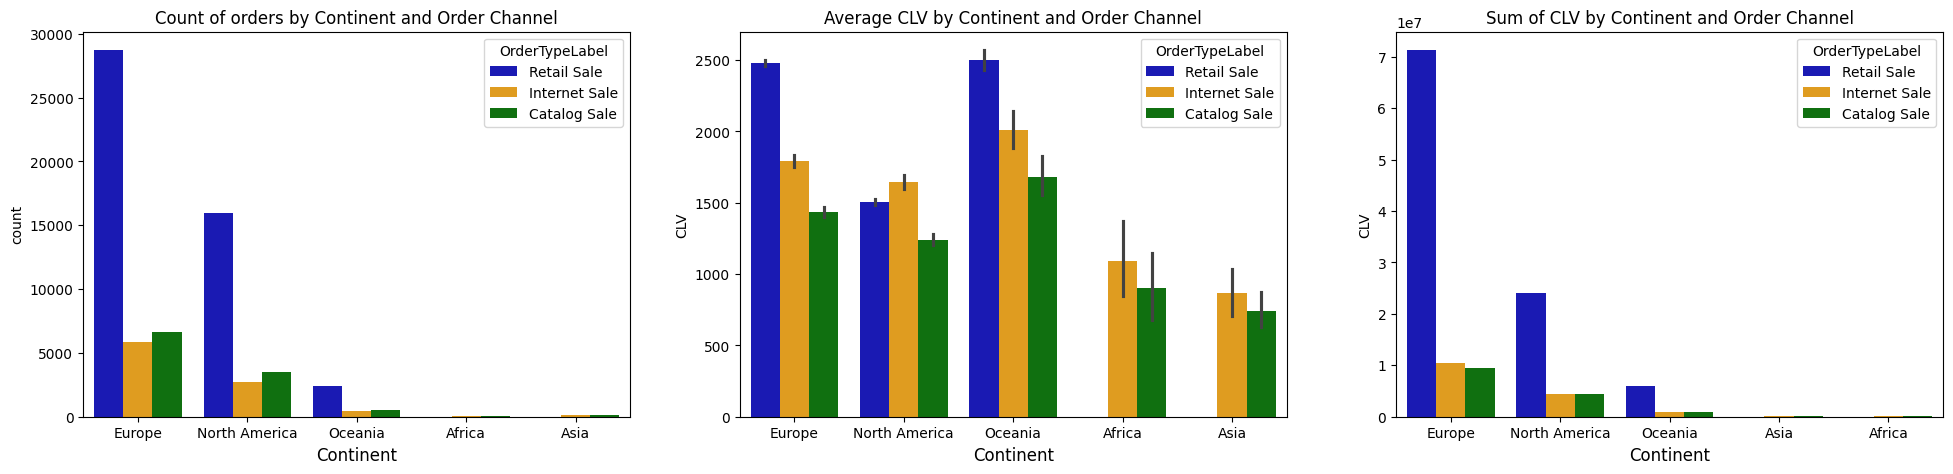

In [ ]:
# c. Orders distributed by continent and channels; Countplot and barplots in grid, of CLV by Continent and OrderTypeLabel

fig, ax = plt.subplots(1,3, figsize=(24, 5))
colour_palette = {'Catalog Sale': 'green', 'Internet Sale': 'orange', 'Retail Sale': 'mediumblue'}

sns.countplot(data=data_aggr, x='Continent', hue='OrderTypeLabel', palette = colour_palette, ax=ax[0])
ax[0].set_title('Count of orders by Continent and Order Channel')
ax[0].set_xlabel('Continent', fontsize=12)

sns.barplot(data=data_aggr, x='Continent', y='CLV', hue='OrderTypeLabel', palette = colour_palette, ax=ax[1])
ax[1].set_title('Average CLV by Continent and Order Channel')
ax[1].set_xlabel('Continent', fontsize=12)

# Aggregate data to sum CLV
data_aggr_sum = data_aggr.groupby(['Continent', 'OrderTypeLabel']).agg({'CLV': 'sum'}).reset_index().sort_values('CLV', ascending = False)

sns.barplot(data=data_aggr_sum, x='Continent', y='CLV', hue='OrderTypeLabel', palette = colour_palette, ax=ax[2])
ax[2].set_title('Sum of CLV by Continent and Order Channel')
ax[2].set_xlabel('Continent', fontsize=12)

plt.show()

c. Europe has the highest number of orders and cummulative CLV before North America and Oceania, with very little orders coming from Africa and Asia. However, in terms of average CLV per customer, Oceania has the highest even though the total cummulative order is small compared to Europe and America. We can also see that customers from Asia and Africa only ordered either by Internet Sale or Catalog Sale. This may be as a result of no physical stores in these locations.

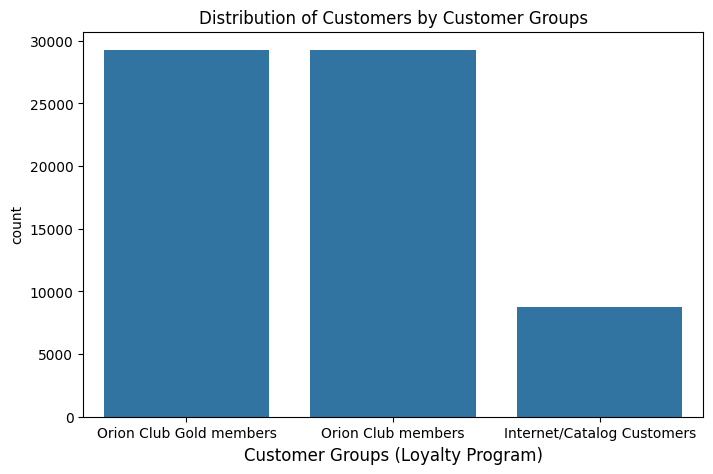

In [ ]:
# d. Customers distributed into Customer Groups; Countplot of customer group

plt.figure(figsize=(8,5))
sns.countplot(data=data_aggr, x='Customer_Group')
plt.title('Distribution of Customers by Customer Groups')
plt.xlabel('Customer Groups (Loyalty Program)', fontsize=12)

plt.show()

d. As expected, most customers are equally distributed under the Orion Club members and Gold members. Only a few customers are in the Internet/Catalog groups.

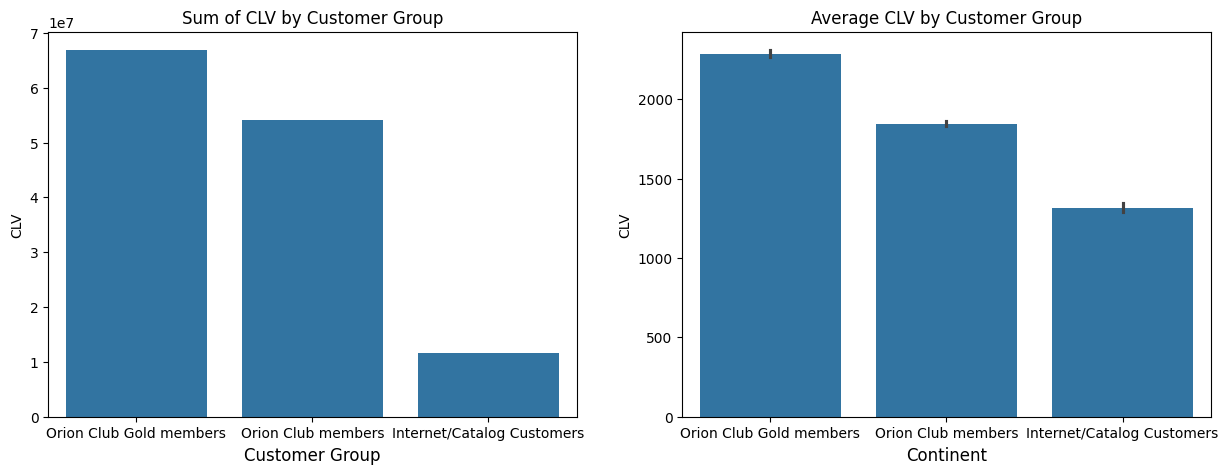

In [ ]:
# e. Customer Groups generating the highest CLV; Barplot of Customer Group vs CLV
fig, ax=plt.subplots(1,2, figsize=(15,5))

# Aggregate data to sum CLV
data_aggr_sum = data_aggr.groupby('Customer_Group').agg({'CLV': 'sum'}).reset_index().sort_values('CLV', ascending = False)

sns.barplot(data=data_aggr_sum, x='Customer_Group', y='CLV', ax=ax[0])
ax[0].set_title('Sum of CLV by Customer Group')
ax[0].set_xlabel('Customer Group', fontsize=12)

sns.barplot(data=data_aggr, x='Customer_Group', y='CLV', ax=ax[1])
ax[1].set_title('Average CLV by Customer Group')
ax[1].set_xlabel('Continent', fontsize=12)

plt.show()

e. As should be expected, although Orion Club members and Gold members have about equal customer population, in terms of CLV the Gold members have generated the highest based on accumulated and average CLV per customer.

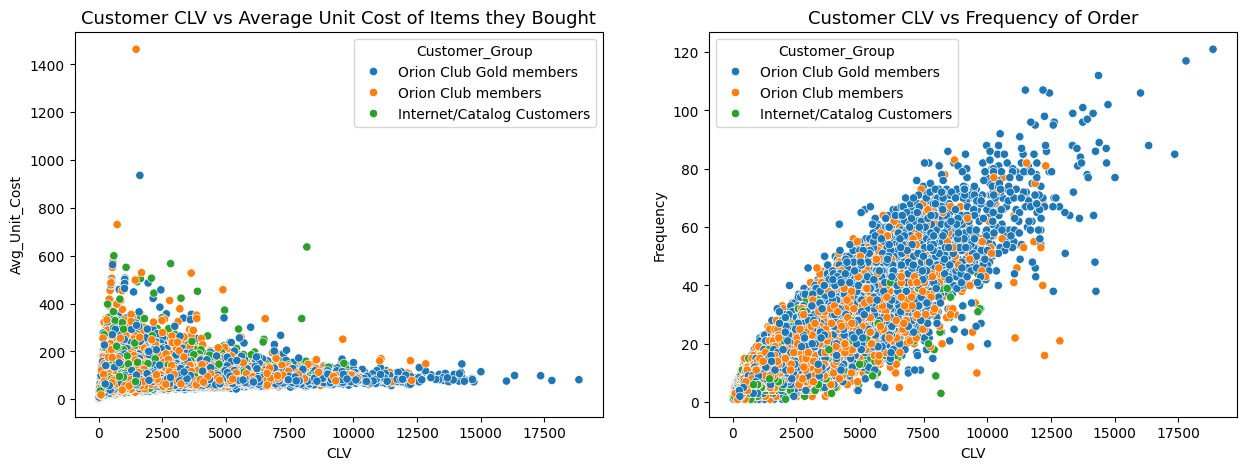

In [ ]:
# f. Are the customers contributing highest CLV also buying the most expensive products?; Scatterplot of CLV vs Unit Cost

fig, ax = plt.subplots(1,2, figsize=(15, 5))

sns.scatterplot(data=data_aggr, x='CLV', y='Avg_Unit_Cost', hue='Customer_Group', ax=ax[0])
ax[0].set_title('Customer CLV vs Average Unit Cost of Items they Bought', fontsize=13)

# g. Scatterplot of frequency vs CLV
sns.scatterplot(data=data_aggr, x='CLV', y='Frequency', hue='Customer_Group', ax=ax[1])
ax[1].set_title('Customer CLV vs Frequency of Order', fontsize=13)

plt.show()

f. Customers with high CLV mainly bought low average unit cost items, but ordered more frequently. The relationship between CLV and Frequency is clearly positive and shows that the customers that ordered more frequently and generated the highest CLV were Gold members, even though these customers mainly purchased low cost items.

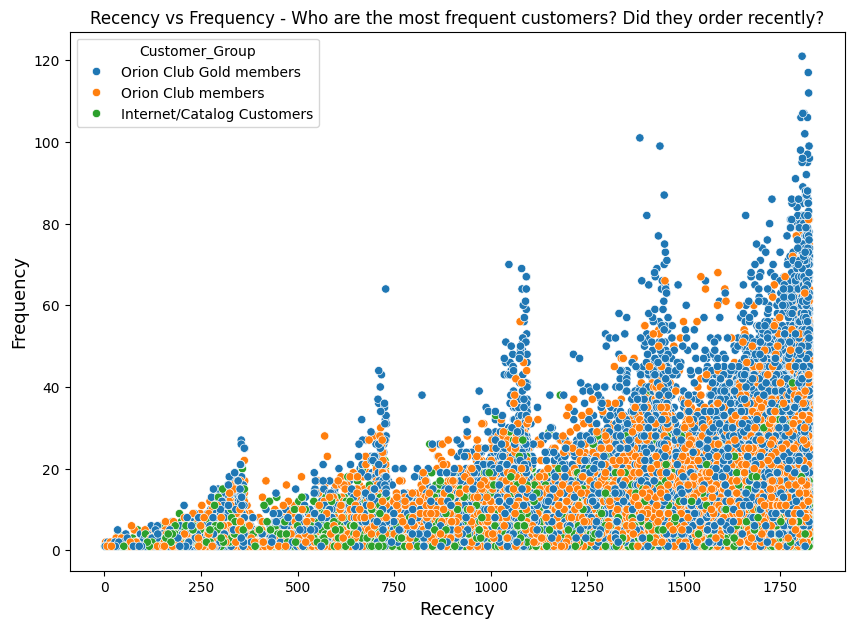

In [ ]:
# g. Relationship between Frequency and Recency; Scatter plot of frequency vs recency

plt.figure(figsize=(10,7))
sns.scatterplot(data=data_aggr, x='Recency', y='Frequency', hue='Customer_Group')
plt.title('Recency vs Frequency - Who are the most frequent customers? Did they order recently?')
plt.xlabel('Recency', fontsize=13)
plt.ylabel('Frequency', fontsize=13)
plt.show()

g. Recency is calculated as the number of days between the very first order in the dataset (1st of January 2012) and when a customer made their most recent order. Therefore, a higher number denotes a more recent order (high recency). Based on the data spread, gold members are seen to have the highest recency and most gold member orders seem to show a seasonal pattern suggesting they may have shopped more during festivities. Also, more customers seem to have ordered more recently than those that have not ordered since the period.

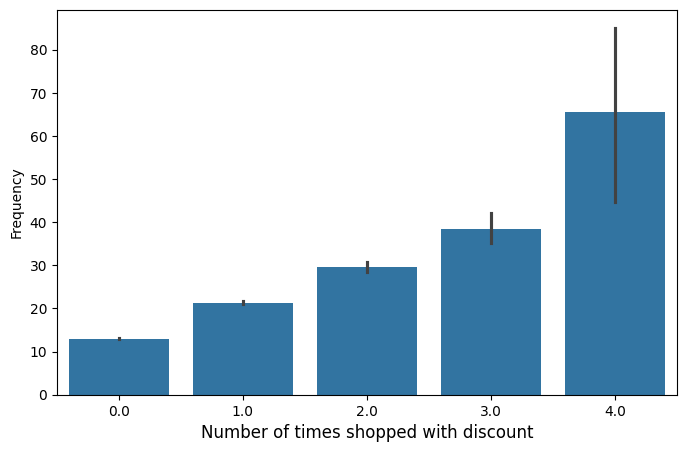

In [ ]:
# h. Customers accessing more discounts; Barplot of frequency vs discount_applied

plt.figure(figsize=(8,5))
sns.barplot(data=data_aggr, x='Discount_Applied', y='Frequency')
plt.xlabel('Number of times shopped with discount', fontsize=12)
plt.show()

h. Out of all the customers that have accessed discounts, those with higher number of discounted orders also shopped more frquently on the average. Going by this, we can say that the business is rewarding frequent shoppers more.

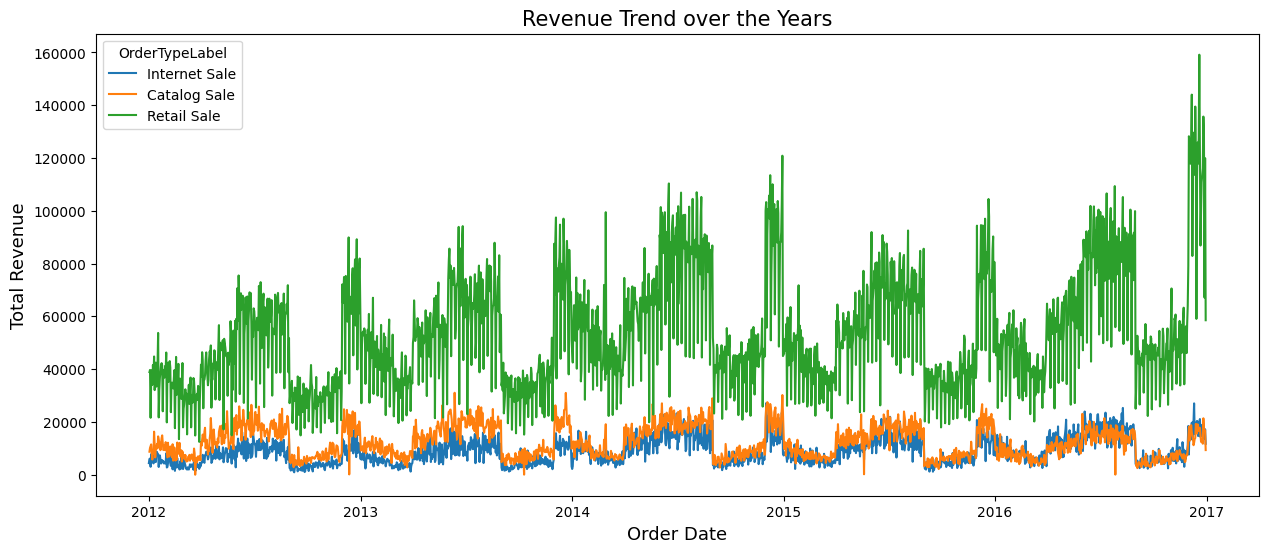

In [ ]:
# i. Total Revenue evolution for the different ordering channels; Line plot of order date vs Total Revenue, hue - OrderTypeLabel

plt.figure(figsize=(15,6))
data_aggr_TR = data_4.groupby(['Order_Date', 'OrderTypeLabel']).agg({'Total Revenue':'sum'}).reset_index()
sns.lineplot(data=data_aggr_TR, x='Order_Date', y='Total Revenue', hue='OrderTypeLabel')
plt.title('Revenue Trend over the Years', fontsize=15)
plt.xlabel('Order Date', fontsize=13)
plt.ylabel('Total Revenue', fontsize=13)
plt.show()


i. Total revenue in retail sale (green) shows overall growth with a peak in December 2016. However, revenue from Catalog sale (orange) seems to have been declining marginally, while Internet sale (blue) have been increasing slowly. It would be interesting to see what these trends will look like after 2020 with the growth of online shopping since Covid.

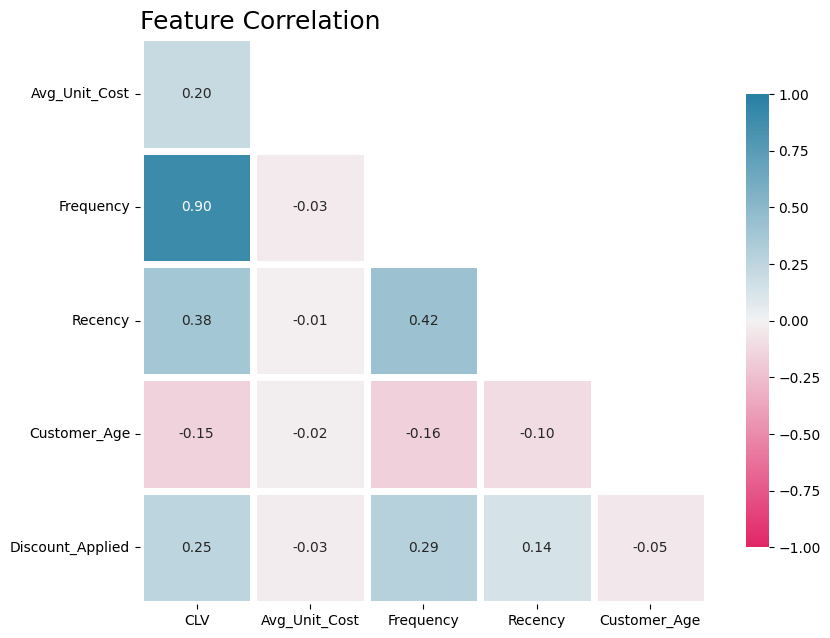

In [ ]:
# j. Visualise correlations between the variables using visualisation

# Use a custom function for reusability
def feature_corr(df, title):
    df_corr = df.corr()
    fig, ax = plt.subplots(figsize=(12, 9))

    mask = np.triu(np.ones_like(df_corr, dtype=bool))
    mask = mask[1:, :-1]
    corr = df_corr.iloc[1:,:-1].copy()

    cmap = sns.diverging_palette(0, 230, 90, 50, as_cmap=True)
    sns.heatmap(corr, mask=mask, annot=True, fmt=".2f",
               linewidths=5, cmap=cmap, vmin=-1, vmax=1,
               cbar_kws={"shrink": .8}, square=True)

    yticks = [i for i in corr.index]
    xticks = [i for i in corr.columns]

    plt.yticks(plt.yticks()[0], labels=yticks, rotation=0)
    plt.xticks(plt.xticks()[0], labels=xticks)

    title = title
    plt.title(title, loc='left', fontsize=18)
    plt.subplots_adjust(bottom=0.25, left=0.25)

    plt.show()

columns = ['CLV', 'Avg_Unit_Cost', 'Frequency', 'Recency', 'Customer_Age', 'Discount_Applied']
feature_corr(df = data_aggr[columns], title = 'Feature Correlation')

j. The highest correlation is between Frequency and CLV (90%) which supports the scatter plot earlier shown. There is also some association between Recency and Frequency/CLV which also supports the visualisations that showed customers who purchased recently also had higher order frequency and CLV. Finally, we can see some small association between Frequency and Discount_Applied as well as Avg_Unit_Cost and CLV.

**5. Incorporate Column Transformer and Pipeline**

In [ ]:
# Create a new dataset suitable for clustering; remove column identifier ('Customer ID')

data_for_clustering = data_aggr.drop(columns='Customer ID')

In [ ]:
print('Number of unique cities: ', data_aggr['City'].nunique())

Number of unique cities:  10470


In [ ]:
# Remove 'City': There are 10,471 cities where customers are located which is too many to provide useful differentiation between customers for clustering

# Drop the City column
data_for_clustering = data_for_clustering.drop(columns=['City'])

# View the first few rows
data_for_clustering.head()

,Continent,CustomerCountryLabel,Customer_Type,Customer_Group,OrderTypeLabel,CLV,Avg_Unit_Cost,Frequency,Recency,Customer_Age,Discount_Applied
0,Europe,France,Orion Club Gold members high activity,Orion Club Gold members,Retail Sale,4322.70,89.622857,35,1808,70,0.0
1,Europe,Italy,Orion Club members high activity,Orion Club members,Internet Sale,2821.00,90.505000,20,1701,40,0.0
2,North America,United States,Orion Club members low activity,Orion Club members,Retail Sale,782.67,37.195556,9,717,40,0.0
3,North America,United States,Orion Club Gold members medium activity,Orion Club Gold members,Retail Sale,2810.98,107.947368,19,1820,35,0.0
4,Europe,Belgium,Orion Club members medium activity,Orion Club members,Internet Sale,1604.58,52.526667,15,1633,65,1.0


In [ ]:
# Import libraries

from sklearn.compose import ColumnTransformer
from sklearn.datasets import fetch_openml
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# Set seed for reproducibility
np.random.seed(20)

In [ ]:
# Incorporate column transformer and create a pipeline

numerical_features = data_for_clustering.select_dtypes('number').columns.tolist()
numeric_transformer = Pipeline(
    steps=[('scaler', StandardScaler())]
)

categorical_features = data_for_clustering.select_dtypes('object').columns.tolist()
categorical_transformer = Pipeline(
    steps=[('encoder', OneHotEncoder(handle_unknown='ignore', sparse=False))]
)
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features),
    ]
)

# Fit the pipeline on the data
preprocessor.fit(data_for_clustering)

# Transform the data to see it's new shape
transformed_data = preprocessor.transform(data_for_clustering)

transformed_data.shape

(67290, 66)

The transformed data now has 66 columns (mainly due to new dummies created from OneHotEncoding), with number of rows remaining the same. Dimensional reduction will be applied to reduce the dimension to 2 variables.

In [ ]:
# Dimension Reduction pipeline with PCA

dimreduc_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("dim_reduction", PCA(n_components=2))  # Reduce to 2 dimensions
])

# Fit the pipeline on the data
dimreduc_pipeline.fit(data_for_clustering)

# Transform the data
twodim_data = dimreduc_pipeline.transform(data_for_clustering)

# Check shape of 2D data after PCA
twodim_data.shape

(67290, 2)

Using PCA, the data dimension has been reduced to 2.

**6. Select the optimum value of clusters (𝑘) with the Elbow and Silhouette score methods.**

The Elbow and Silhouette methods are techniques for determining the optimum number of clusters when using a KMeans clustering system. These methods will be applied in the following steps.

**a. Elbow Method**

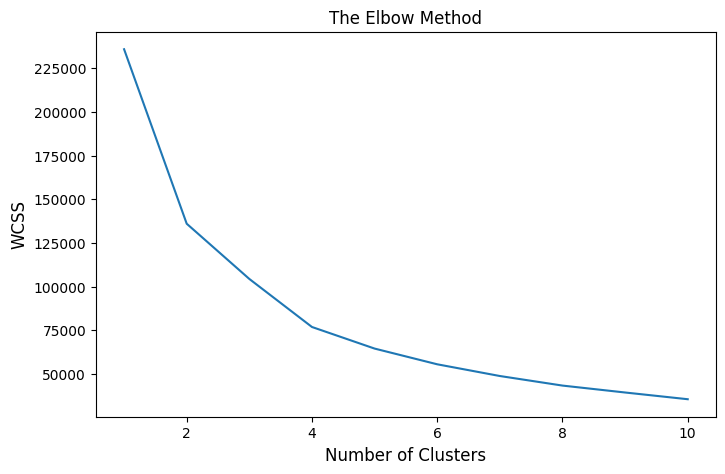

In [ ]:
# Elbow method: try different k.
wcss=[]
for i in range(1,11):
    kmeans=KMeans(n_clusters=i, init='k-means++',random_state=0, n_init = 10)
    kmeans.fit(twodim_data)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(8,5))
plt.plot(range(1,11),wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of Clusters', fontsize=12)
plt.ylabel('WCSS', fontsize=12)
plt.show()

Change in Within Cluster Sum of Squares (WCSS) starts to flatten out from 4 clusters, which indicates that 4 may be a good balance of intra-cluster similarity vs number of customer clusters. It is important to set the most efficient number of clusters for market targetting, while ensuring that each cluster maintain enough silmilarity within for effective marketting campaigns. We will also consider the Silhouette method to make more informed dicision.

**b. Silhouette Method**

In [ ]:
# Import necessary library.
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

For n_clusters = 2 ; The average silhouette_score is : 0.41174945955966324
For n_clusters = 3 ; The average silhouette_score is : 0.3788548764744279
For n_clusters = 4 ; The average silhouette_score is : 0.37053896203636677
For n_clusters = 5 ; The average silhouette_score is : 0.33176569115412285
For n_clusters = 6 ; The average silhouette_score is : 0.33534999150947586


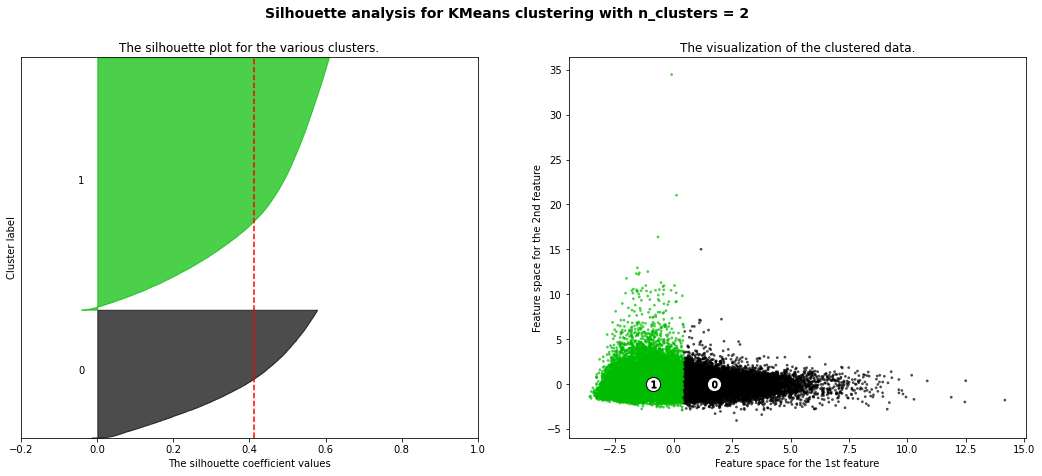

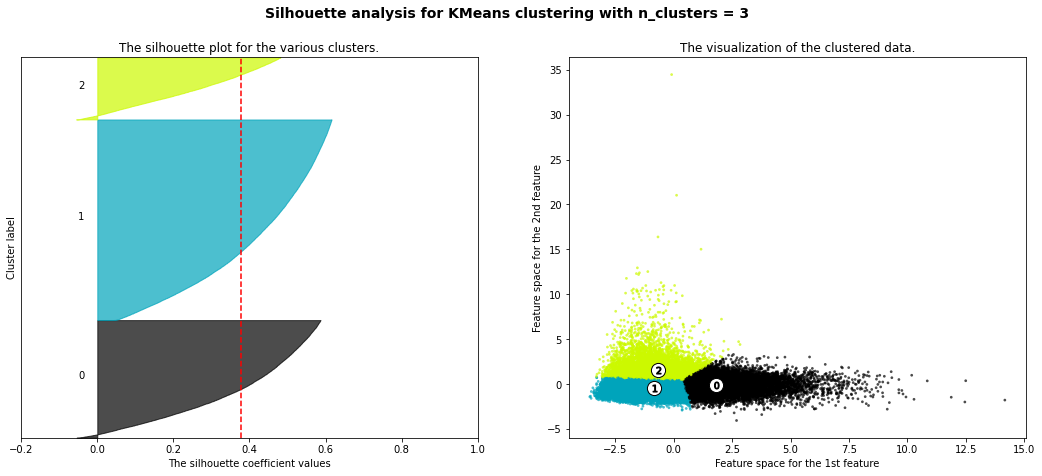

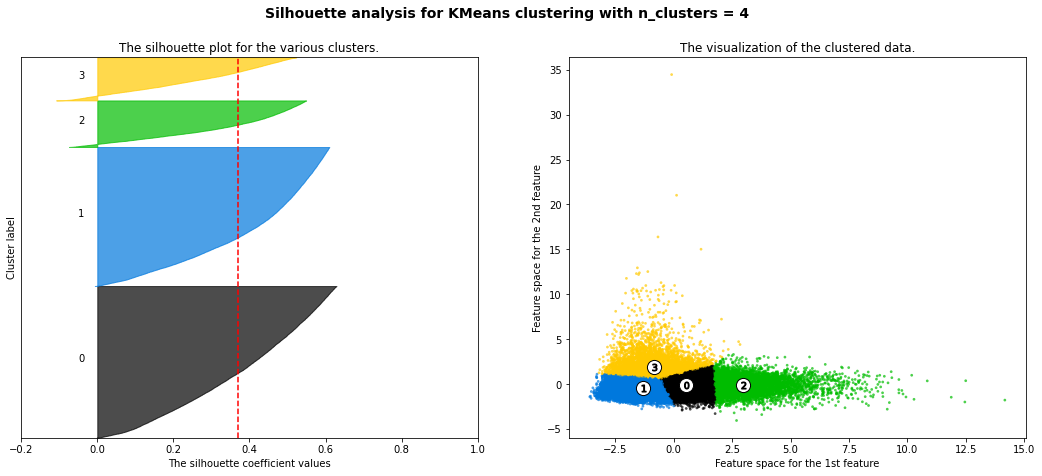

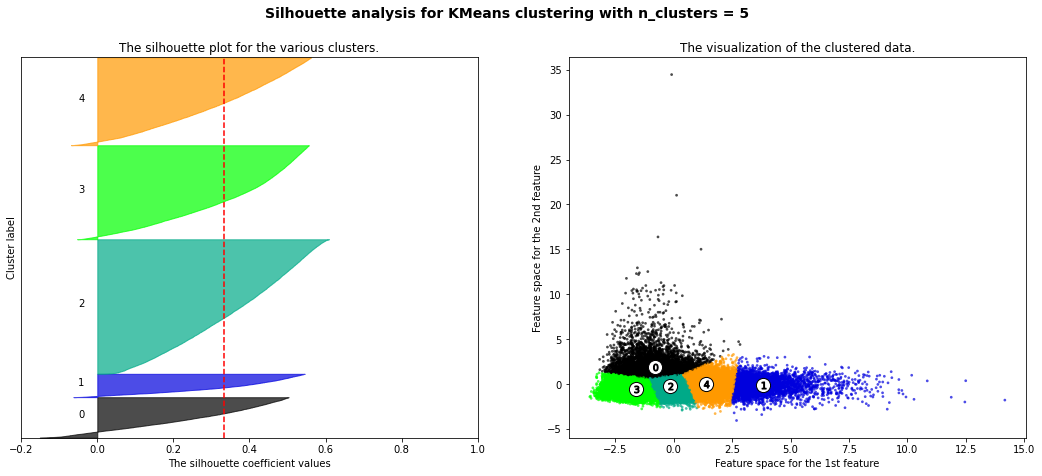

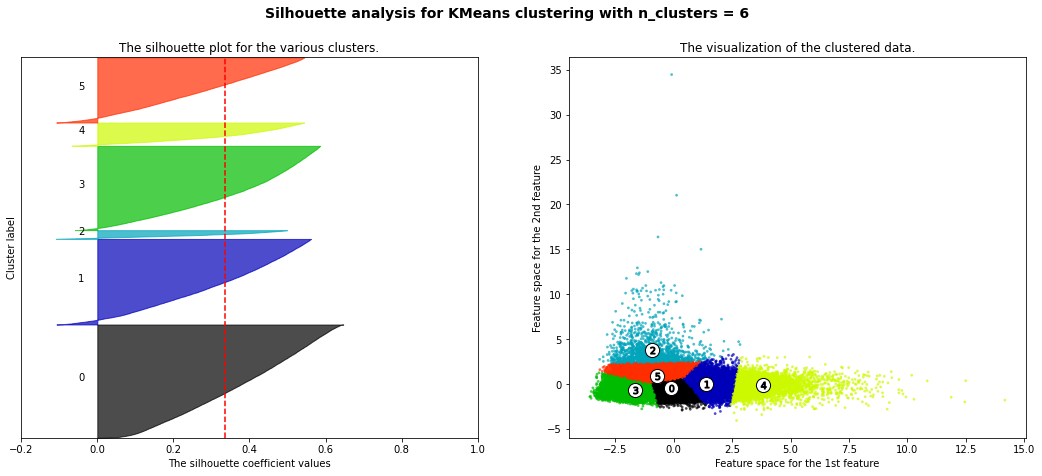

In [ ]:
range_n_clusters = [2, 3, 4, 5, 6]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns.
    fig, ax = plt.subplots(1, 2, figsize=(18, 7))

    # The 1st subplot is the silhouette plot.
    # The silhouette coefficient can range from -1, 1 however the lowest here is -0.2 so we use [-0.2, 1].
    ax[0].set_xlim([-0.2, 1])

    # The (n_clusters+1)*10 inserts a blank space between silhouette plots of individual clusters to demarcate them clearly.
    ax[0].set_ylim([0, len(twodim_data) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator seed of 20 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=20, n_init = 10)
    cluster_labels = clusterer.fit_predict(twodim_data)

    # The silhouette_score gives the average value for all the samples, giving a perspective into the density and separation of formed clusters
    silhouette_avg = silhouette_score(twodim_data, cluster_labels)
    print("For n_clusters =", n_clusters,"; "
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(twodim_data, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them.
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax[0].fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle.
        ax[0].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot.
        y_lower = y_upper + 10  # 10 for the 0 samples.

    ax[0].set_title("The silhouette plot for the various clusters.")
    ax[0].set_xlabel("The silhouette coefficient values")
    ax[0].set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values.
    ax[0].axvline(x=silhouette_avg, color="red", linestyle="--")

    ax[0].set_yticks([])  # Clear the yaxis labels / ticks.
    ax[0].set_xticks([-0.2, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed.
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax[1].scatter(twodim_data[:, 0], twodim_data[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters.
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers.
    ax[1].scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax[1].scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax[1].set_title("The visualization of the clustered data.")
    ax[1].set_xlabel("Feature space for the 1st feature")
    ax[1].set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

The clustered data scatter plots show that most data points are clumped around one area with little distinct gaps, hence we see some negative Silhouette scores for all cluster numbers (2 - 8 clusters). While 2 and 3 clusters show higher overall Silhouette scores, they also show an uneven distribution by having one or two massive cluster(s) with high Silhouette score, and other small clusters with low scores. However, 4 clusters show two big and two small clusters with highest tip exceeding 0.5 for all. Above 4 clusters there seem to be a sharp decline in the overall Silouette score indicating an important decrease in the intra-cluster cohesion. We shall proceed with 4 clusters.

**7. Hierarchical Clustering - Dendogram**

We shall use scikit-lear to perform the hierarchical clustering and visualise using a dendogram.

In [ ]:
# Import libraries

from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage

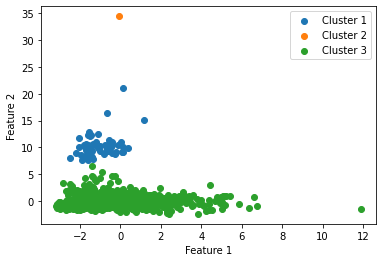

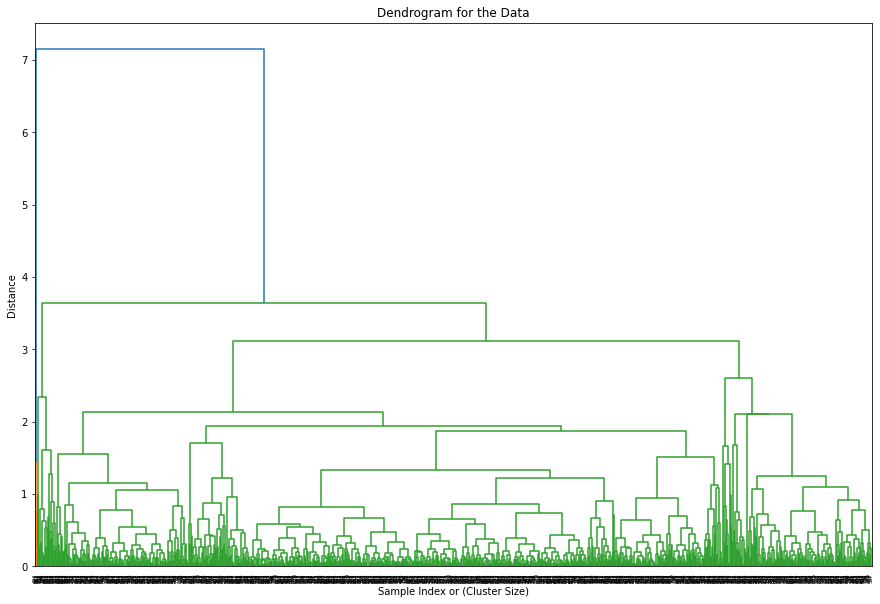

In [ ]:
# Perform Hierarchical Agglomerative Clustering
agglo_cluster = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='average')
cluster_labels = agglo_cluster.fit_predict(twodim_data)

# Plotting the clusters
for cluster_idx in range(3):  # Adjust range according to the number of clusters
    cluster_data = twodim_data[cluster_labels == cluster_idx]
    sample_indices = np.random.choice(len(cluster_data), size=min(1000, len(cluster_data)), replace=False)
    plt.scatter(cluster_data[sample_indices, 0], cluster_data[sample_indices, 1], label=f'Cluster {cluster_idx + 1}')

plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.show()

# Creating the linkage matrix and plotting the dendrogram
sample_indices = np.random.choice(len(twodim_data), size=min(1000, len(twodim_data)), replace=False)
Z = linkage(twodim_data[sample_indices], method='average')
plt.figure(figsize=(15, 10))
dendrogram(Z)
plt.title('Dendrogram for the Data')
plt.xlabel('Sample Index or (Cluster Size)')
plt.ylabel('Distance')
plt.show()

The heirarchical method was highly computing intensive, therefore a sample of 1000 records was generated randomly from the data for the heirarchical clustering. Drawing a horizontal line at distance 2.5 suggests 4 clusters may be ideal for the data. However, the scatter plot shows some data points far distant from the rest hence behaving like outliers, therefore we can see that the majority of datapoints are assigned to cluster 3, while the outlier is assigned to its own cluster 2. The result of the dendogram and scatter plot combined with the high computing requirement, show that heirarchical clustering is not the best option for this data.

**8. Based on the optimum number of 𝑘, perform k-means clustering**

As seen in the Elbow, Silhouette and heirarchical methods, 4 clusters seems to provide the right balance of a cohesive enough clusters and a realistic number of clusters for effective marketing campaigns targeting each cluster. Therefore we shall apply KMeans with 4 target clusters. In performing the KMeans cluster, the ColumnTransformed data with 66 features may lead to better clustering result, however it may also create some issues such as:

1. **Curse of Dimensionality:** with 66 features (high dimensional spaces) the concept of distance is less meaningful, which can impact the performance of the  distance-based KMeans clustering.
2. **Computational Cost:** A high-dimensional data of 66 features may significantly increase the computational cost and time required for clustering.
3. **Interpretability:** It can be more challenging to interpret the results of clustering a high number of features.

Based on the above considerations, we shall use the PCA 2D data (twodim_data) earlier obtained from preprocessing pipeline in step 5.

In [ ]:
# Perform k-means clustering with 4 clusters using scikit-learn.
kmeans = KMeans(n_clusters=4, random_state=42,  n_init=10)
cluster_labels_KM = kmeans.fit_predict(twodim_data)

# Extracting centroids.
centroids = kmeans.cluster_centers_

# Print final centroids.
print("Final Centroids:", centroids)

Final Centroids: [[ 0.53201504 -0.08745545]
 [-1.29167465 -0.46104229]
 [ 2.99178461 -0.05802983]
 [-0.83183153  1.8784181 ]]


In [ ]:
# Add the cluster labels to the original dataset
data_aggr['Cluster'] = cluster_labels_KM + 1

# Verify the result
data_aggr.head()

,Customer ID,Continent,CustomerCountryLabel,Customer_Type,City,Customer_Group,OrderTypeLabel,CLV,Avg_Unit_Cost,Frequency,Recency,Customer_Age,Discount_Applied,Cluster
0,1,Europe,France,Orion Club Gold members high activity,Paris,Orion Club Gold members,Retail Sale,4322.70,89.622857,35,1808,70,0.0,3
1,3,Europe,Italy,Orion Club members high activity,Bologna,Orion Club members,Internet Sale,2821.00,90.505000,20,1701,40,0.0,1
2,4,North America,United States,Orion Club members low activity,Denver,Orion Club members,Retail Sale,782.67,37.195556,9,717,40,0.0,2
3,5,North America,United States,Orion Club Gold members medium activity,South Gate,Orion Club Gold members,Retail Sale,2810.98,107.947368,19,1820,35,0.0,1
4,6,Europe,Belgium,Orion Club members medium activity,Genk,Orion Club members,Internet Sale,1604.58,52.526667,15,1633,65,1.0,1


The KMeans created 4 clusters of 0 - 3, however with the addition of 1 to each assigned cluster number we now have clusters 1 - 4 for better interpretability. The first 5 rows of the DataFrame show some cluster labels of 1, 2 and 3. We can see that a cluster number of 1 is assigned to customers with medium activity, 2 for customers with low activity and 3 for a customer with high activity. Using boxplot visualisation of clusters with regards to the set metrics; Frequency, Recency, CLV and Average Unit Cost, the cluster assignment can be better explained.

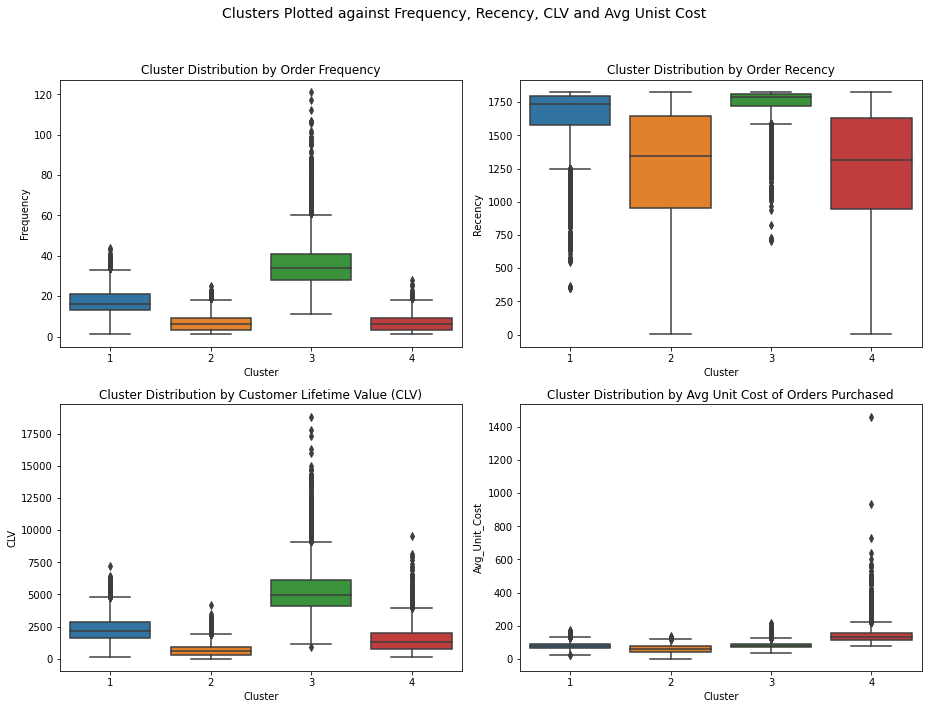

In [ ]:
# Plot boxplots of cluster assignments vs Frequency, Recency, CLV and Average Unit Cost

# Set the plot axes
fig, ax=plt.subplots(2,2, figsize=(13,10))

# Creat boxplots
sns.boxplot(data=data_aggr, x='Cluster', y='Frequency', ax=ax[0,0])
ax[0,0].set_title('Cluster Distribution by Order Frequency')

sns.boxplot(data=data_aggr, x='Cluster', y='Recency', ax=ax[0,1])
ax[0,1].set_title('Cluster Distribution by Order Recency')

sns.boxplot(data=data_aggr, x='Cluster', y='CLV', ax=ax[1,0])
ax[1,0].set_title('Cluster Distribution by Customer Lifetime Value (CLV)')

sns.boxplot(data=data_aggr, x='Cluster', y='Avg_Unit_Cost', ax=ax[1,1])
ax[1,1].set_title('Cluster Distribution by Avg Unit Cost of Orders Purchased')

# Set a global title of the plots
plt.suptitle(("Clusters Plotted against Frequency, Recency, CLV and Avg Unist Cost"), fontsize=14)
plt.subplots_adjust(top=0.9, bottom=0.2)

# Show plots
plt.tight_layout(rect=[0, 0, 1, 0.95])
# plt.tight_layout()
plt.show()

The above boxplots show that:

1. **Cluster 1:** Medium frequency (around 20), high recency, medium CLV (approx. 2500 on avg) and low unit cost items. This cluster indicates a group of customers that are becoming more loyal to the brand with more regular orders in recent times.

2. **Cluster 2:** Low frequency, low relative recency, low CLV and low unit cost items. This cluster suggests a group of customer with low activity and brand loyalty who have shopped less than 10 times. These customers could use some tailored marketing campaigns like bespoke promotions to drive more engagement from them.

3. **Cluster 3:** High frequency, high recency, high CLV and low unit cost items. This cluster aligns more with Gold members with high activity, with high brand loyalty. These customers shop very frequently for things like groceries, etc. These customers will remain loyal with small perks such as early access discounts and points for purchase, etc.

4. **Cluster 4:** Low frequency, lower relative recency, low CLV and high Avg Unit Cost. These customers probably appear once a while specifically for bigger purchases like outdoor furniture, car accessories, etc. They probably live too far away to do their weekly grocery shopping in store. It may be beneficial to offer these types of customers free delivery options to their doorstep which may drive more activity from them.

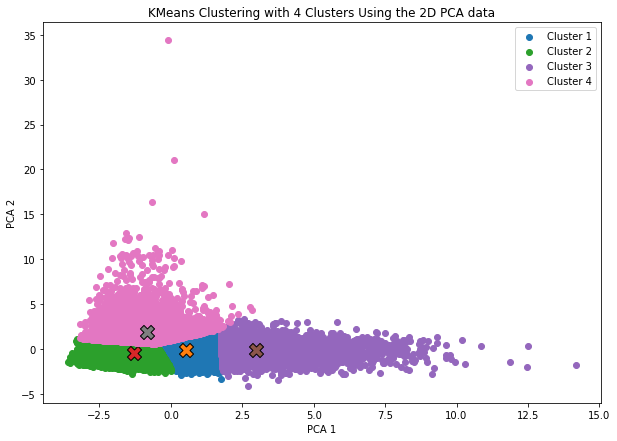

In [ ]:
# Set plot size
plt.figure(figsize=(10,7))

# Plotting the clusters and centroids.
for cluster_idx in range(4):
    # cluster_data = data[data['cluster'] == cluster_idx]
    cluster_data = twodim_data[cluster_labels_KM == cluster_idx]
    plt.scatter(cluster_data[:, 0], cluster_data[:, 1], label=f'Cluster {cluster_idx + 1}')
    plt.scatter(*centroids[cluster_idx], s=200, marker='X', edgecolor='black')

plt.title('KMeans Clustering with 4 Clusters Using the 2D PCA data')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
# plt.xlim(145, 200)
# plt.ylim(40, 145)
plt.legend()
plt.show()

The 2D data is visualised showing all the clusters and their centroids. We can see that the data points are closely packed together, however the KMeans still manages to create 4 clusters with clear boundaries of split. While the heirarchical clustering did not rely on a target number of clusters as the KMeans, however the KMeans performed better with outliers (data points that are far off from others) and saved computing time, making it the preferred option over heirarchical clustering.

# Conclusion
This project demonstrates the application of end-to-end clustering techniques to a real-world e-commerce dataset. The workflow included data manipulation, cleaning, and feature engineering; exploratory data analysis to uncover initial insights; preprocessing with scaling and dimensionality reduction using pipelines; and determining the optimum number of clusters through the Elbow and Silhouette methods. Both hierarchical clustering and KMeans were trialled.

A key consideration was the computational cost of clustering high-dimensional, large-scale data. Hierarchical clustering required random sampling due to its heavy resource demands, limiting its suitability for the full dataset. In contrast, KMeans was more efficient, scalable, and interpretable for this use case. On balance, KMeans with four clusters was selected as the most appropriate model, producing meaningful segments that can inform targeted marketing strategies.


### Reference:
SAS, 2024. CUSTOMERS_CLEAN [Data set]. SAS. Last revised on 15 December 2021. [Accessed 20 February 2024].